In [23]:
import numpy as np
def y(ti, dti, Na, Nb,l_a = None, l_b = None): 
    return Na*np.exp(-l_a*ti)*(1 - np.exp(-l_a*dti))+Nb*np.exp(-l_b*ti)*(1 - np.exp(-l_b*dti))

In [15]:
import pandas as pd
import os
data = pd.read_csv(r'C:\Users\Gustavo\Documents\GitHub\Estatastica-com-Python\dadosAtividadePratica_4.txt', delimiter='\t')
print(data)
ti = np.array(data['t(h)'])
dti = np.array(data['dt(h)'])
y_data = np.array(data['n'])
s_y = np.array(data['sigma'])

   t(h)  dt(h)      n  sigma
0   0.5    1.5  16183    133
1   2.2    1.5   5453     84
2   3.9    1.5   2646     65
3   5.5    3.0   2900     76
4   8.7    4.0   1688     76


In [30]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

la = 0.203
lb = 0.92
D = 0.001

la1 = la + D
lb2 = lb + D

V_l = (10**(-4))*np.array([[0.81, 0], [0, 3.24]])

ti_dti_data = np.vstack((ti, dti))

N, V_y = curve_fit(lambda td, Na, Nb: y(td[0], td[1], Na, Nb, l_a = la, l_b = lb), ti_dti_data, y_data, absolute_sigma = True, sigma = s_y)


N1, V_y1 = curve_fit(lambda td, Na, Nb: y(td[0], td[1], Na, Nb, l_a = la1, l_b = lb), ti_dti_data, y_data, absolute_sigma = True, sigma = s_y)


N2, V_y2 = curve_fit(lambda td, Na, Nb: y(td[0], td[1], Na, Nb, l_a = la, l_b = lb2), ti_dti_data, y_data, absolute_sigma = True, sigma = s_y)


N_a, N_b = N
N_1a, N_1b = N1
N_2a, N_2b = N2 

F11 = (N_1a - N_a)/D
F12 = (N_2a - N_a)/D

F21 = (N_1b - N_b)/D
F22 = (N_2b - N_b)/D

F = np.array([[F11, F12],[F21, F22]])

V_final = V_y + F @ V_l @ F.T



In [60]:
def plot(sigmoid, t_data, t2_data, y_data, norm_res, popt, title = None, l_a = None, l_b = None, ti = 's'):
    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True,
                                figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    y = sigmoid(t_data, t2_data, popt[0], popt[1], l_a = la, l_b = lb)
    
    norm_res = ((y_data - y)**2)/(norm_res**2)
    
    if ti != 's':
        ax1.scatter(t2_data, y_data, label='Dados')
        ax1.plot(t2_data, sigmoid(t_data, t2_data, popt[0], popt[1], l_a = la, l_b = lb), color='red',label=f'Ajuste (Na={np.round(popt[0], 2)}, Nb={np.round(popt[1], 3)})')
        t_data = t2_data
    else:
        ax1.scatter(t_data, y_data, label='Dados')
        ax1.plot(t_data, sigmoid(t_data, t2_data, popt[0], popt[1], l_a = la, l_b = lb), color='red',label=f'Ajuste (Na={np.round(popt[0], 2)}, Nb={np.round(popt[1], 3)})')
    ax1.legend()
    ax1.errorbar(t_data, y_data, yerr=s_y,fmt="o", label="Dados Experimentais")
    ax1.set_title(title)
    ax2.scatter(t_data, norm_res)
    ax2.hlines(y=0, xmin = 0, xmax = max(t_data), color = "r", linestyle = "-.")
    ax2.errorbar(t_data, norm_res, yerr= 1, fmt='none')
    ax2.set_ylabel("Resíduo normalizado")
    plt.xlabel("t (s)")
    fig.subplots_adjust(hspace=0.02)
    plt.show()

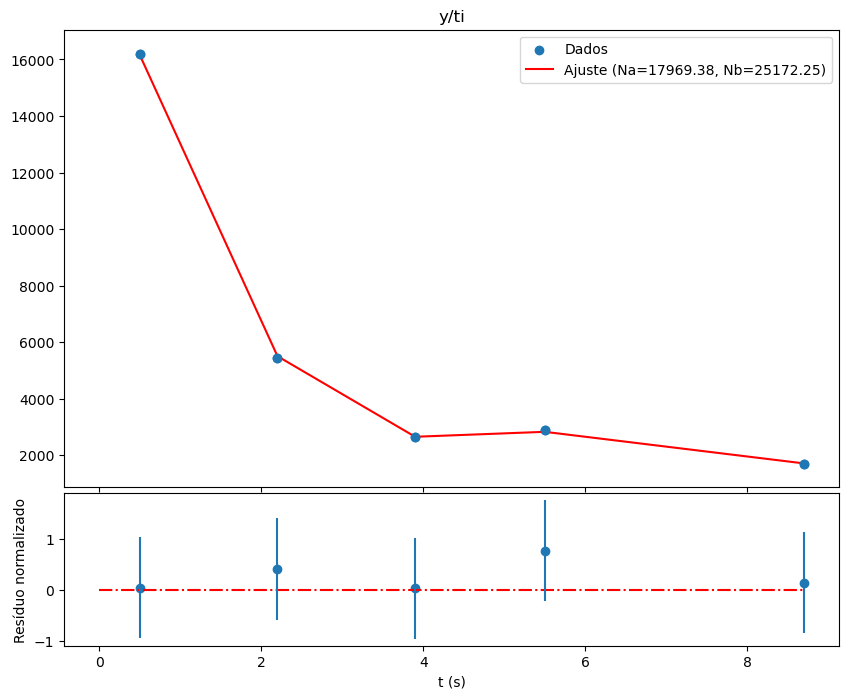

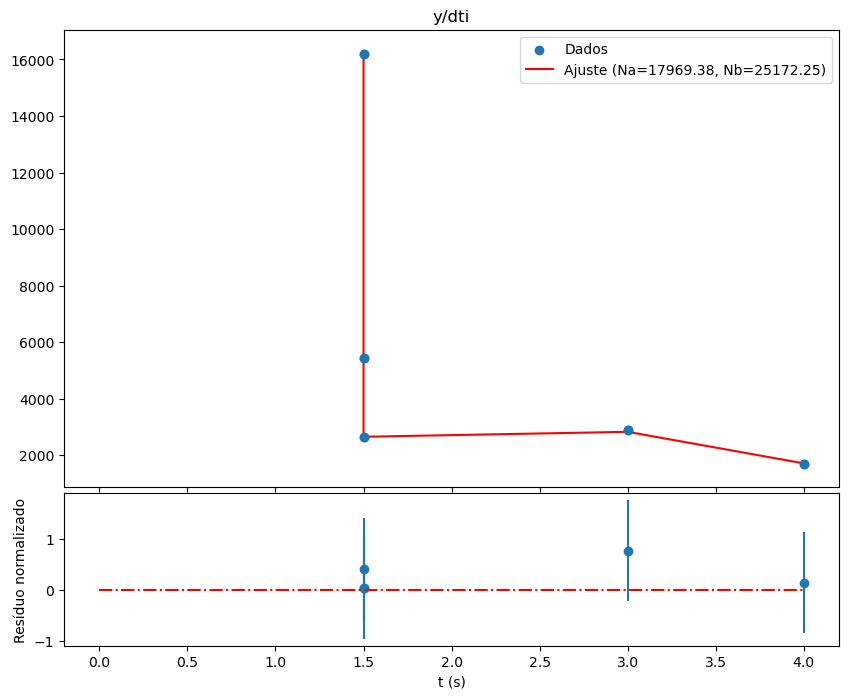

In [61]:
plot(y, ti, dti, y_data, s_y, N, title = 'y/ti',l_a = la, l_b = lb)
plot(y, ti, dti, y_data, s_y, N, title = 'y/dti',l_a = la, l_b = lb, ti = 'n')

In [32]:
V_final

array([[ 212288.52931858, -196268.7322835 ],
       [-196268.7322835 ,  349707.4125486 ]])